In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
header_list = ["tweetid","userid","user_display_name","user_screen_name","user_reported_location","user_profile_description","user_profile_url","follower_count","following_count","account_creation_date","account_language","tweet_language","tweet_text","tweet_time","tweet_client_name","in_reply_to_tweetid","in_reply_to_userid","quoted_tweet_tweetid","is_retweet","retweet_userid","retweet_tweetid","latitude","longitude","quote_count","reply_count","like_count","retweet_count","hashtags","urls","user_mentions","poll_choices"]
header_dict = {val:i for i,val in enumerate(header_list)}

In [18]:
import sys

def parse(f,chunksize = 100000, cols = None, test_bool = False, dtype = None):
    lines = 9041*1000
    for i,gm_chunk in enumerate(pd.read_csv("../ira_tweets_csv_hashed.csv",chunksize = chunksize, usecols = cols, dtype = dtype)):
        f(gm_chunk)
        if test_bool:
            print('Done')
            break
        j = i*chunksize/lines
        sys.stdout.write('\r')
        # the exact output you're looking for:
        bar_int = int(j*20+1)
        sys.stdout.write("[%-20s] %d%%" % ('='*bar_int, int(j*100+1)))
        sys.stdout.flush()

In [20]:
global df_test
def f(chunk):
    global df_test
    df_test = chunk

parse(f, 2, test_bool = True)

Done


In [21]:
df_test[:1].to_string()

'              tweetid                                             userid                                  user_display_name                                   user_screen_name user_reported_location user_profile_description  user_profile_url  follower_count  following_count account_creation_date account_language tweet_language                                         tweet_text        tweet_time tweet_client_name  in_reply_to_tweetid  in_reply_to_userid  quoted_tweet_tweetid  is_retweet  retweet_userid  retweet_tweetid  latitude  longitude  quote_count  reply_count  like_count  retweet_count hashtags                                          urls user_mentions  poll_choices\n0  877919995476496385  249064136b1c5cb00a705316ab73dd9b53785748ab757f...  249064136b1c5cb00a705316ab73dd9b53785748ab757f...  249064136b1c5cb00a705316ab73dd9b53785748ab757f...         Москва, Россия    Я примерный семьянин!               NaN             132              120            2013-12-07               ru      

In [22]:
cols = header_dict['hashtags']
global hashtag_set
hashtag_set = set()
def f(chunk):
    hashtag_set = hashtag_set.union(set(str(h) for h in chunk[cols]))

parse(f, 10000,cols = None, test_bool = True)    

UnboundLocalError: local variable 'hashtag_set' referenced before assignment

In [23]:
cols = [header_dict['follower_count'], header_dict['userid']]
global follower_dict
follower_dict = defaultdict()
def f(chunk):
    global follower_list
    for count,userid in zip(chunk['follower_count'], chunk['userid']):
        follower_dict[userid] =  count

parse(f, 10000,cols = cols, test_bool = False)    

[====================] 100%

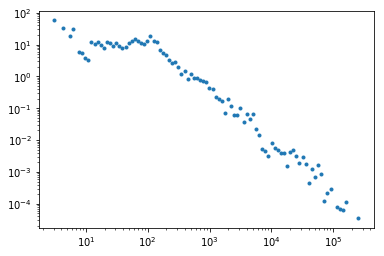

In [24]:
foll_count = np.array(list(follower_dict.values()))

bins = np.exp( np.linspace(1,np.log(max(foll_count)), 100) )
follower_hist, bins = np.histogram(foll_count, bins = bins)

follower_hist = follower_hist/(bins[1:] - bins[:-1])

plt.loglog(bins[1:], follower_hist, marker = '.', linestyle = ' ')

In [25]:
cols = [header_dict['like_count']]
#global like_array
like_array = []
def f(chunk):
    like_array.extend(chunk['like_count'])

parse(f, 50000,cols = cols, test_bool = False)  

[====================] 100%

In [26]:
like_array = [i for i in like_array if i == i]
sum([i == 0 for i in like_array]), max(like_array)

(8197082, 325826.0)

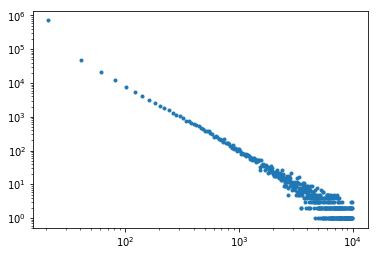

In [27]:
hist = np.histogram(like_array, bins = np.linspace(1,10000,500))
plt.loglog(hist[1][1:], hist[0], '.')

(25000, 270519.7640859086)

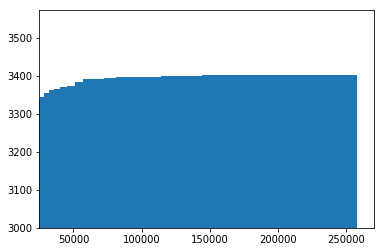

In [28]:
_ = plt.hist(foll_count, bins = bins, cumulative= True)
plt.ylim(3000,)
plt.xlim(25000,)

In [29]:
sum([c > 3000 for c in foll_count])

277

In [30]:
cols = ['retweet_tweetid', 'tweetid']
global t_rt_dict
t_rt_dict = defaultdict()
def f(chunk):
    for rt_id, t_id in zip(chunk['tweetid'], chunk['retweet_tweetid']):
        if t_id == t_id and rt_id == rt_id:
            t_rt_dict[int(t_id)] = int(rt_id)
        

parse(f, 100000, cols = cols, test_bool = False)    

[====================] 100%

In [31]:
from collections import Counter
rt_count = Counter(t_rt_dict.values())

In [32]:
cols = ['retweet_tweetid']
global rt_ids_list
global rt_ids_set
global rt_ids_count
rt_ids_count = defaultdict(int)
rt_ids_list = []
rt_ids_set = set()

def f(chunk):
    #rt_ids_set = rt_ids_set.union(chunk['retweet_tweetid'])
    for rt_id in chunk['retweet_tweetid']:
        if rt_id == rt_id:
            rt_id = int(rt_id)
            rt_ids_set.add(rt_id)
            rt_ids_list.append(rt_id)
            rt_ids_count[rt_id] += 1

parse(f, 100000, cols = cols, test_bool = False)  

[====================] 100%

In [33]:
len(rt_ids_list) - len(rt_ids_set)

1607343

In [34]:
len(rt_ids_set), len(rt_ids_list)

(1725841, 3333184)

In [35]:
# the values are the number of tweets that were retweeted key times
# keys is how often the retweet was retweeted

rt_count = Counter(rt_ids_count.values())

(array([1.366476e+06, 2.423370e+05, 7.909500e+04, 1.879800e+04,
        8.470000e+03, 3.046000e+03, 2.016000e+03, 1.349000e+03,
        1.416000e+03]),
 array([ 0.        ,  2.22222222,  4.44444444,  6.66666667,  8.88888889,
        11.11111111, 13.33333333, 15.55555556, 17.77777778, 20.        ]),
 <a list of 9 Patch objects>)

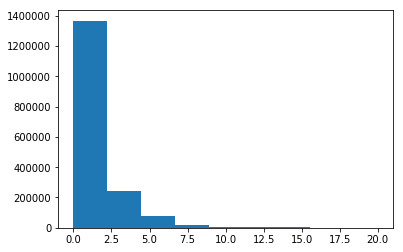

In [36]:
c_bins = np.linspace(0, 20, 10)
plt.hist(rt_ids_count.values(), bins = c_bins)

In [37]:
sum( True for retw_count in rt_ids_count.values() if retw_count > 600)

2

In [38]:
import networkx as nx

In [39]:
global G
G = nx.Graph()
hashtag_set = set()
def f(chunk):
    for uid, fc in zip(chunk['userid'], chunk['follower_count']):
        G.add_node(uid)
            
parse(f, 40000,cols = ['userid', 'follower_count'], test_bool = False)    

[====================] 100%

In [40]:
global nset
nset = set(G.nodes())

In [41]:
len(G.nodes())

3667

In [42]:
cols = ["in_reply_to_userid", "userid"]

global id_rep_id
id_rep_id = defaultdict(int)

def f(chunk):
    #rt_ids_set = rt_ids_set.union(chunk['retweet_tweetid'])
    for uid, rid in zip(chunk['userid'], chunk['in_reply_to_userid']):
        if rid in nset and uid in nset:
            id_rep_id[(uid, rid)] += 1
            

parse(f, 100000, cols = cols, test_bool = False)   

[====================] 100%

In [43]:
cols = ["retweet_userid", "userid"]

id_retw_id = defaultdict(int)

def f(chunk):
    #rt_ids_set = rt_ids_set.union(chunk['retweet_tweetid'])
    for uid, rtwid in zip(chunk['userid'], chunk['retweet_userid']):
        if rtwid in nset and uid in nset:
            id_retw_id[(uid, rtwid)] += 1
            

parse(f, 100000, cols = cols, test_bool = False)   

[====================] 100%

In [44]:
for e,w in id_retw_id.items():
    G.add_edge(e[0], e[1], weight = w)

In [45]:
for e,w in id_rep_id.items():
    G.add_edge(e[0], e[1], weight = w)

In [46]:
T = nx.Graph()
T.add_edge("hi", "this")
nx.write_gexf(T, "small_test.gexf")

In [47]:
comp_G = list(nx.connected_component_subgraphs(G))

In [48]:
sG = nx.subgraph(G, [n for n,d in G.degree() if d > 0])

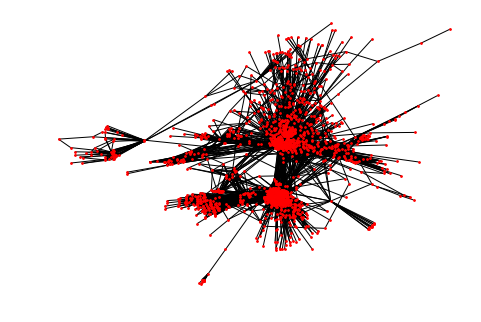

In [49]:
nx.draw(comp_G[0], pos =  nx.spring_layout(comp_G[0]), node_size = 3)

In [59]:
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt

forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          edgeWeightInfluence=0.4,

                          # Performance
                          jitterTolerance=0.2, # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.2,

                          # Tuning
                          scalingRatio=5.0,
                          strongGravityMode=False,
                          gravity=0.03,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(comp_G[0].to_undirected(), pos=None, iterations = 500)

100%|██████████| 500/500 [02:53<00:00,  2.60it/s]

BarnesHut Approximation  took  51.34  seconds
Repulsion forces  took  110.80  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  9.76  seconds
AdjustSpeedAndApplyForces step  took  0.49  seconds


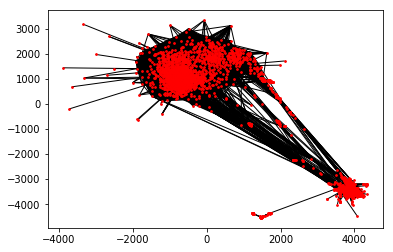

In [56]:
nx.draw_networkx(comp_G[0], positions, cmap=plt.get_cmap('jet'), node_size=3, with_labels=False)
plt.show()

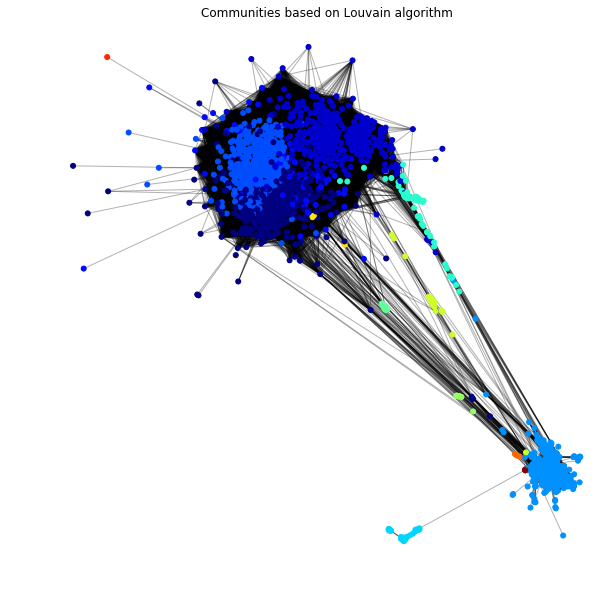

In [58]:
import community

#find partitions of a graph
H = comp_G[0].to_undirected()
isolates = nx.isolates(H)
#print(list(isolates))
H.remove_nodes_from(list(isolates))
partition = community.best_partition(H)

size = float(len(set(partition.values())))
count = 0.

plt.figure(3,figsize=(10,10)) 
colors = [partition[n] for n in H.nodes()]


nx.draw_networkx_nodes(H, positions, node_color=colors, 
                         with_labels=False, node_size=25, cmap=plt.cm.jet,)


nx.draw_networkx_edges(H, positions, alpha=0.3)
plt.title("Communities based on Louvain algorithm")
plt.axis('off')
plt.show()